In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from torch.utils.data import DataLoader, TensorDataset

In [2]:
imgs = torch.load("linear_imgs.pt")

In [3]:
imgs = imgs.squeeze(1)

In [4]:
imgs.shape

torch.Size([10000, 76, 77])

In [5]:
# plt.imshow(sample_imgs[3])

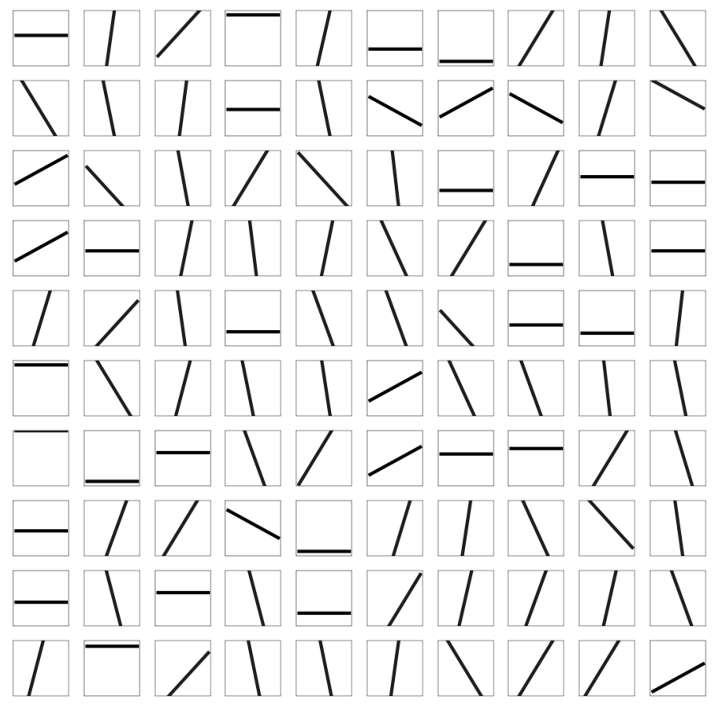

In [6]:
# num_samples = 25
sample_imgs = [i for i in imgs]

fig = plt.figure(figsize=(9, 9))
grid = ImageGrid(fig, 111, nrows_ncols=(10,10), axes_pad=0.1)

for ax, im in zip(grid, sample_imgs):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
plt.show()

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

mps


In [8]:
dataset = TensorDataset(imgs)
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(76 * 77, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 76 * 77),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(-1, 76*77)
        logits = self.linear_relu_stack(x)
        return logits

In [10]:
model = NeuralNetwork().to(device)

In [11]:
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=5852, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=5852, bias=True)
    (7): Sigmoid()
  )
)


In [12]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)

In [13]:
def train(data, model, loss_fn, optimizer, id):
    size = len(data)
    model.train()
    loss_total = 0

    for x in dataloader:
        x = x[0].to(device)
        
        pred = model(x)
        loss = loss_fn(pred, x.view(-1, 76*77))
        loss_total += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    if (id % 30 == 0):
        print(loss_total)
    

In [14]:
train(imgs, model, loss_fn, optimizer, 1)

In [15]:
for i in range(1000):
    train(imgs, model, loss_fn, optimizer, i)

2.421416662633419
1.2338007483631372
0.8826348262373358
0.6851878508459777
0.5897375971544534
0.529514750582166
0.47108042892068624
0.43572361511178315
0.41855563689023256
0.387912780395709
0.37141507130581886
0.3558553464245051
0.34839928278233856
0.3269528921227902
0.31785285542719066
0.3100359611562453
0.30284976307302713
0.29562146379612386
0.2897860143566504
0.2835827999515459
0.2743090055882931
0.2770991998258978
0.2738872332847677
0.2642586656147614
0.26082119904458523
0.2621326269581914


KeyboardInterrupt: 

In [16]:
to_print = []

for i in range(25):
    pred = model(imgs[i].to(device))
    pred = pred.view(76,77)
    to_print += [imgs[i], pred.to("cpu").detach().numpy()]

In [17]:
# to_print

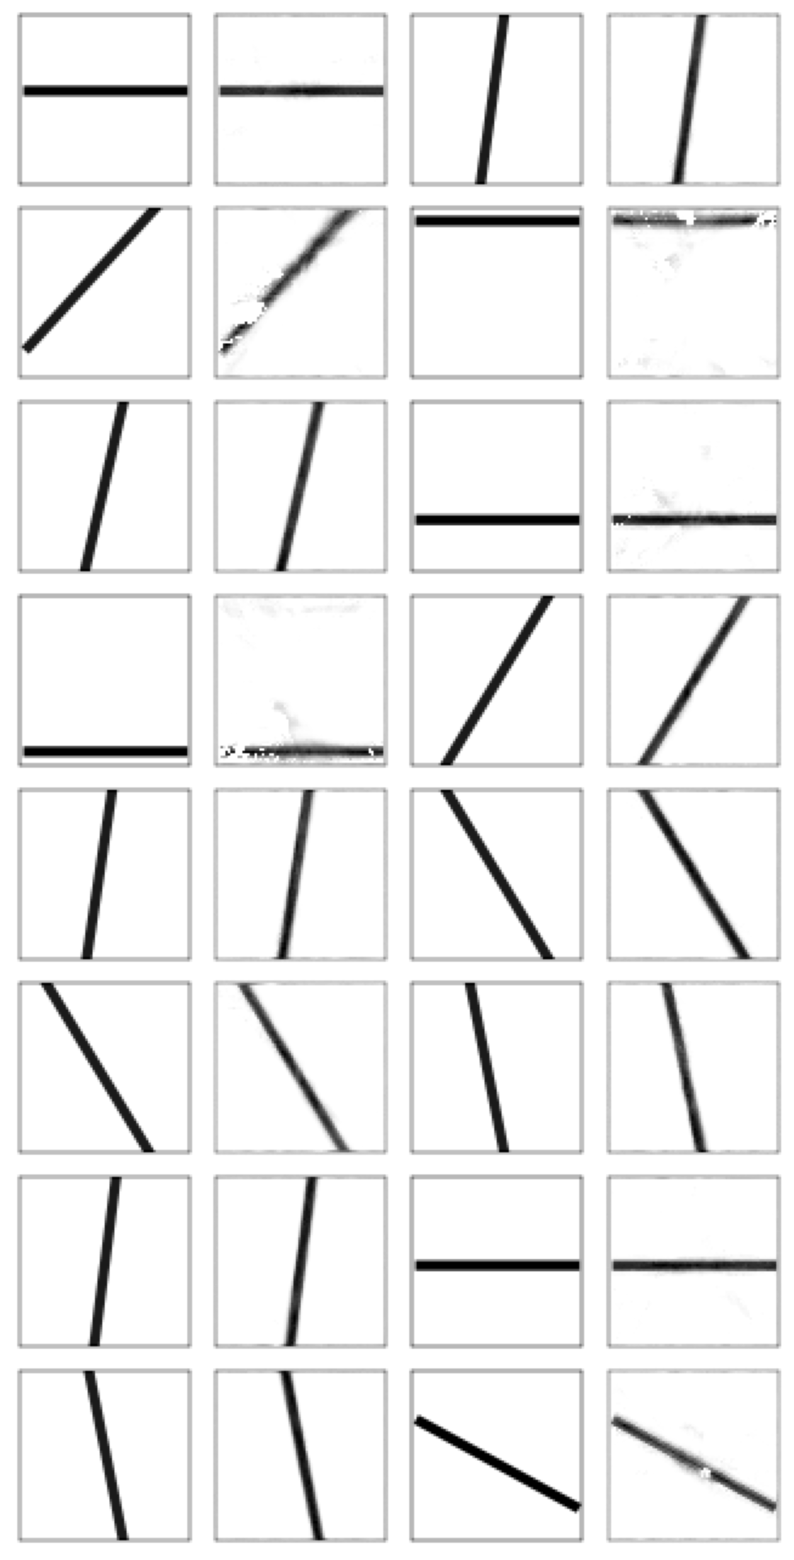

In [18]:
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111, nrows_ncols=(8,4), axes_pad=0.1)

for ax, im in zip(grid, to_print):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
plt.show()